# Features comparison, LSTM models

This notebook discusses predictions made using some different feature- and target combinations. The models used (*A*, *B*, *C*, *D* and *E*) are as described in the thesis. A quick summary:
- **Model A** uses three temperatures and process flow rate to predict outlet cooling temperature
- **Model B** uses three temperatures, process flow rate and coolant valve opening to predict outlet cooling temperature
- **Model C** uses three temperatures, process flow rate and coolant flow rate to predict outlet cooling temperature
- **Model D** uses three temperatures, process flow rate, coolant valve opening and coolant inlet pressure to predict outlet cooling temperature
- **Model E** uses three temperatures, process flow rate, coolant valve opening, coolant flow rate and coolant inlet pressure to predict outlet cooling temperature

The stateful high-level module is used with some additional methods. The functionality of this notebook exceeds the primary intents for the high-level module, and thus does not follow the same recipe as the *basic examples*. Understanding the implemented python methods is not required in order to interpret the results, and therefore the implementation is not discussed in detail.

In [1]:
# %load 3_model_comp.py
import src.core as mlModule
from src.utils.plots import (plotModelPredictions, plotModelScores, getPlotColors)
from src.utils.prints import (printModelScores)
import matplotlib.pyplot as plt
import src.core_configs as configs

Using TensorFlow backend.


In [2]:
colors = getPlotColors()
models = ['A', 'B', 'C', 'D', 'E']

In [3]:
def featureComparison(
    irrelevantColumnsList,
    filename,
    columns,
    traintime,
    testtime,
    targetColumns,
    enrolWindow,
    ):
    global colors, models

    columnsLists = []
    deviationsLists= []
    names = []
    trainmetrics = []
    testmetrics = []

    for i, irrelevantColumns in enumerate(irrelevantColumnsList):
        mlModule.reset()
        df = mlModule.initDataframe(filename, columns, irrelevantColumns)
        df_train, df_test = mlModule.getTestTrainSplit(traintime, testtime)
        X_train, y_train, X_test, y_test = mlModule.getFeatureTargetSplit(targetColumns)

        #mlp_1 = mlModule.MLP('MLP 1x64 d0.2 mod'+models[i], layers=[64], dropout=0.2)
        #mlp_2 = mlModule.MLP('MLP 1x128 d0.2 mod'+models[i], layers=[128], dropout=0.2)
        #mlp_3 = mlModule.MLP('MLP 2x64 d0.2 mod'+models[i], layers=[64, 64], dropout=0.2)
        #mlp_4 = mlModule.MLP('MLP 2x128 d0.2 mod'+models[i], layers=[128, 128], dropout=0.2)
        #lstm_1 = mlModule.LSTM('LSTM 1x64 d0.2 mod'+models[i], layers=[64], dropout=0.2, recurrentDropout=0.2, enrolWindow=12)
        lstm_2 = mlModule.LSTM('LSTM 1x128 d0.2 mod'+models[i], layers=[128], dropout=0.2, recurrentDropout=0.2, enrolWindow=12)
        #lstm_3 = mlModule.LSTM('LSTM 2x64 d0.2 mod'+models[i], layers=[64, 64], dropout=0.2, recurrentDropout=0.2, enrolWindow=12)
        #lstm_4 = mlModule.LSTM('LSTM 2x128 d0.2 mod'+models[i], layers=[128, 128], dropout=0.2, recurrentDropout=0.2, enrolWindow=12)
        #linear = mlModule.Linear_Regularized('Linear rCV mod'+models[i])

        modelList = [
            #mlp_1,
            #mlp_2,
            #mlp_3,
            #mlp_4,
            #lstm_1,
            lstm_2,
            #lstm_3,
            #lstm_4,
            #linear,
        ]

        mlModule.initModels(modelList)
        retrain=False
        mlModule.trainModels(retrain)

        modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlModule.predictWithModels(plot=True, score=True)

        if i < 1:
            columnsLists = columnsList
            deviationsLists = deviationsList
            all_names = modelNames
            all_train_metrics = metrics_train
            all_test_metrics = metrics_test
        else:
            for j_target in range(len(columnsList)):
                for k_model in range(1, len(columnsList[j_target])):
                    columnsLists[j_target].append(columnsList[j_target][k_model])
                for k_model in range(0, len(deviationsList[j_target])):
                    deviationsLists[j_target].append(deviationsList[j_target][k_model])
            all_names = [*all_names, *modelNames]
            all_train_metrics = [*all_train_metrics, *metrics_train]
            all_test_metrics = [*all_test_metrics, *metrics_test]

        names.append(modelNames)
        trainmetrics.append(metrics_train)
        testmetrics.append(metrics_test)

    indexColumn = mlModule._indexColumn
    columnDescriptions = mlModule._columnDescriptions
    columnUnits = mlModule._columnUnits
    traintime = mlModule._traintime

    for i in range(len(deviationsLists)):
        for j in range(len(deviationsLists[i])):
            deviationsLists[i][j][3] = colors[j]

    for i in range(len(columnsLists)):
        columnsList[i][0][3] = 'red'
        for j in range(1, len(columnsLists[i])):
            columnsLists[i][j][3] = colors[j-1]

    printModelScores(
        all_names,
        all_train_metrics,
        all_test_metrics,
    )
    plotModelPredictions(
        plt,
        deviationsLists,
        columnsLists,
        indexColumn,
        columnDescriptions,
        columnUnits,
        traintime,
        interpol=False,
    )
    plotModelScores(
        plt,
        all_names,
        all_train_metrics,
        all_test_metrics,
    )

# Dataset D, predictive models A-E

In [4]:
filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig('D', None, '30min')
targetColumns = [
	'50TT002',
]
irrelevantColumnsList = [
	#  Target: C T out
	#  Featers: P T in, P T out, P flow, C T in 
	[
		'20PT001',
		'50PDT001',
		'50FT001',
		'50TV001',
		'50PT001',
	    '20PDT001',
	],
	#  Target: C T out
	#  Featers: P T in, P T out, P flow, C T in, C valve
	[
		'20PT001',
		'50PDT001',
		'50FT001',
		'50PT001',
	    '20PDT001',
	],
	#  Target: C T out
	#  Featers: P T in, P T out, P flow, C T in, C flow
	[
		'20PT001',
		'50PDT001',
		'50TV001',
		'50PT001',
	    '20PDT001',
	],
	#  Target: C T out
	#  Featers: P T in, P T out, P flow, C T in, C P in, C valve
	[
		'20PT001',
		'50PDT001',
		'50FT001',
	    '20PDT001',
	],
	#  Target: C T out
	#  Featers: P T in, P T out, P flow, C T in, C P in, C valve, C flow
	[
		'20PT001',
		'50PDT001',
	    '20PDT001',
	],
]

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model LSTM 1x128 d0.2 modA was loaded from file
+----------------------+-----------+------

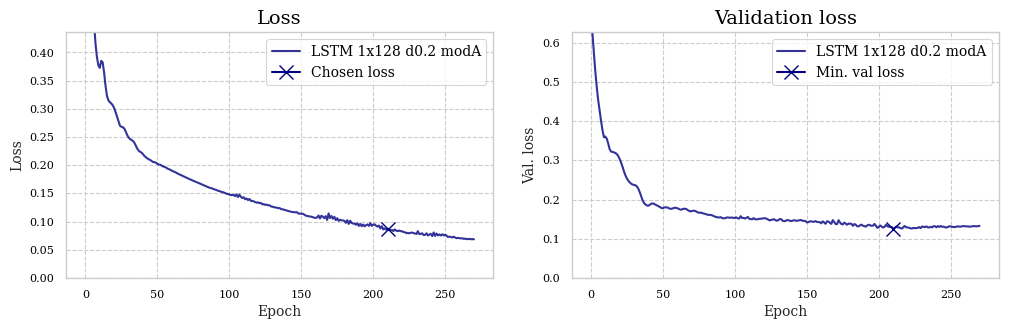

Model prediction scores
+----------------------+-------------+------------+
|        Model         | Train score | Test score |
+----------------------+-------------+------------+
| LSTM 1x128 d0.2 modA |    0.9698   |   0.4128   |
+----------------------+-------------+------------+


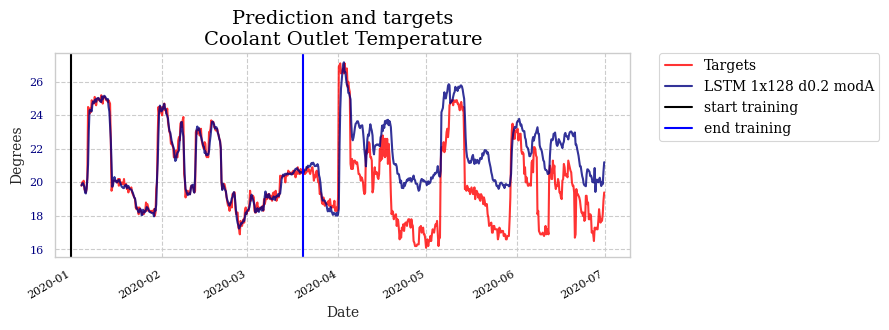

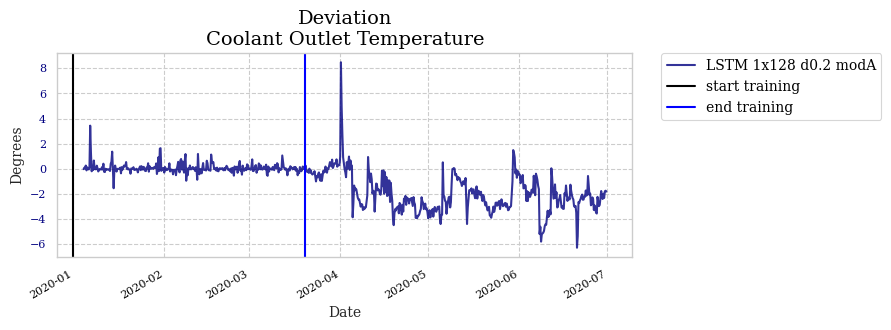

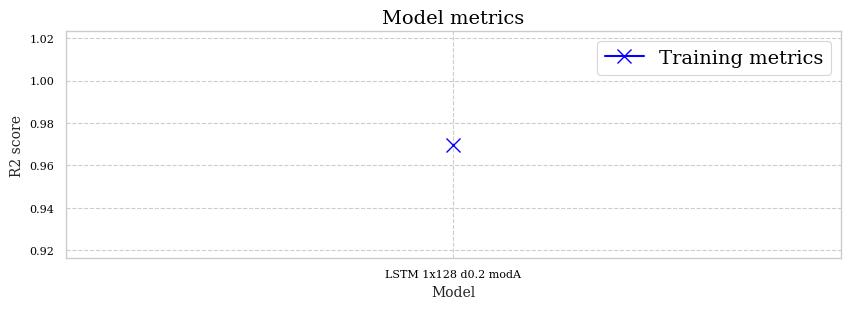

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature
Col. 5 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model LSTM 1x128 d0.2 modB was loaded from file
+

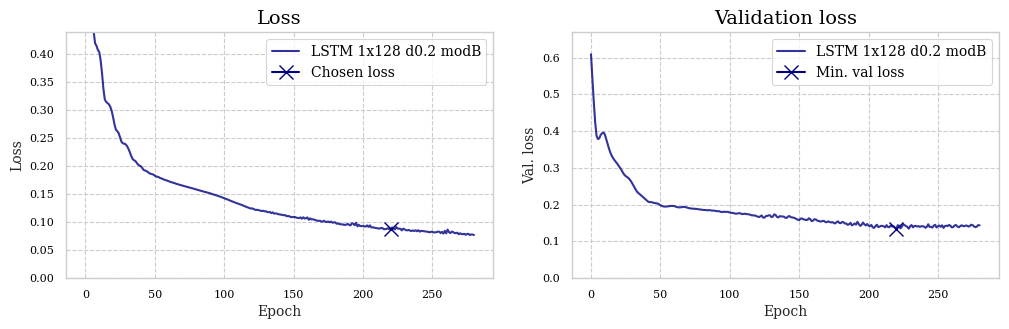

Model prediction scores
+----------------------+-------------+------------+
|        Model         | Train score | Test score |
+----------------------+-------------+------------+
| LSTM 1x128 d0.2 modB |    0.9623   |   0.8373   |
+----------------------+-------------+------------+


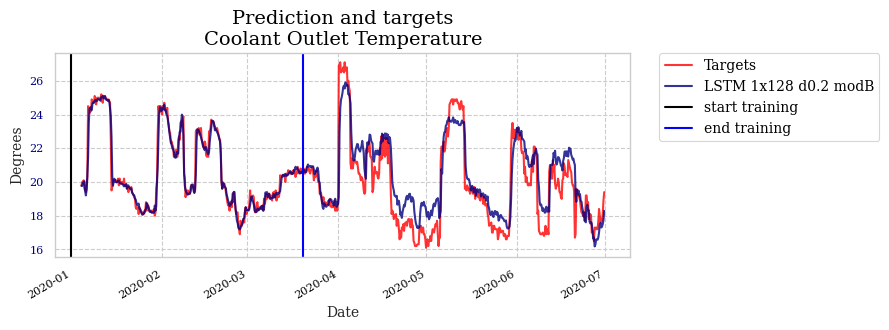

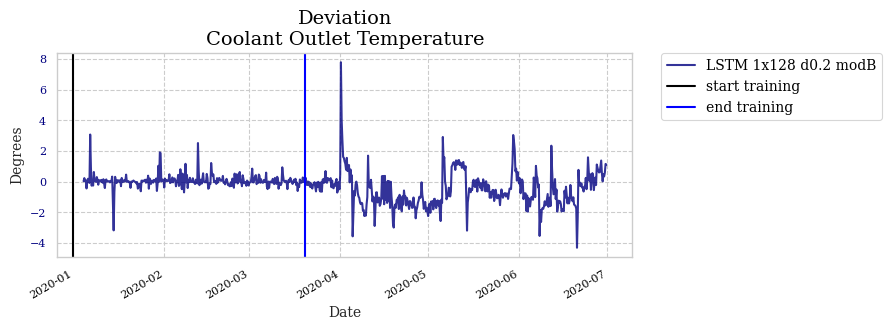

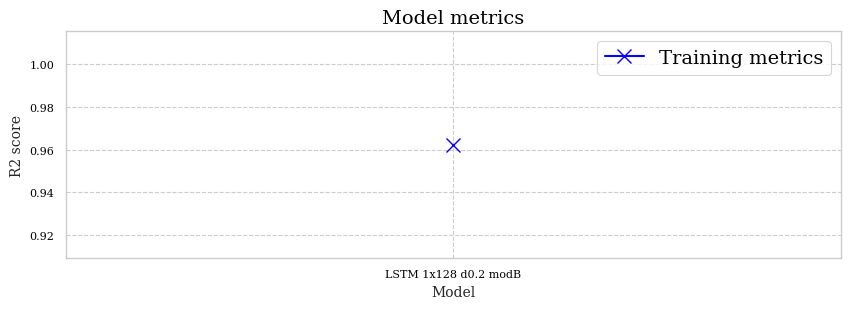

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50FT001 - Coolant Flow Rate
Col. 5 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model LSTM 1x128 d0.2 modC was loaded from file
+----

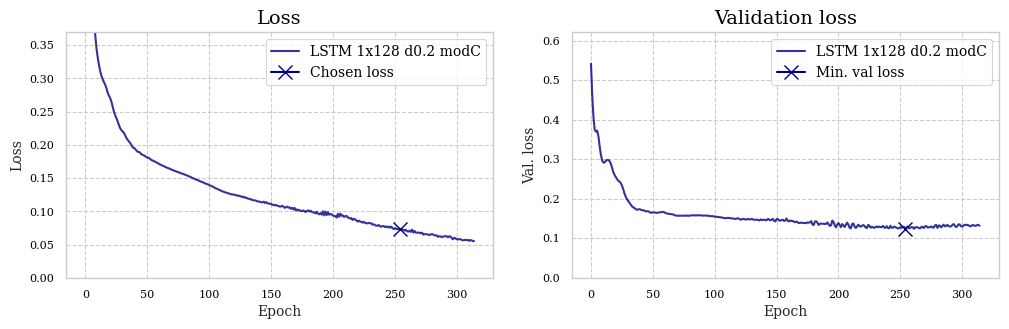

Model prediction scores
+----------------------+-------------+------------+
|        Model         | Train score | Test score |
+----------------------+-------------+------------+
| LSTM 1x128 d0.2 modC |    0.9761   |   0.8493   |
+----------------------+-------------+------------+


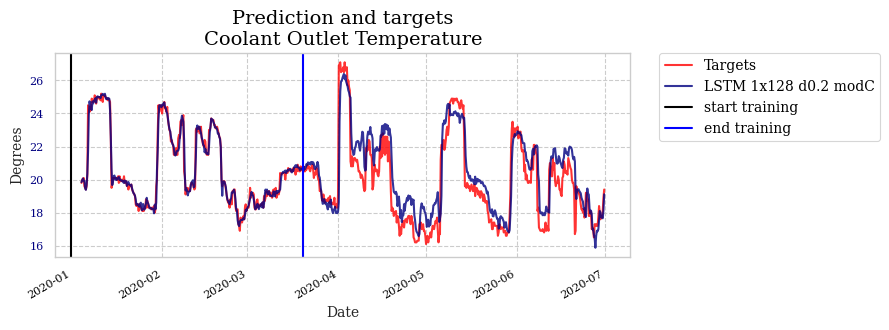

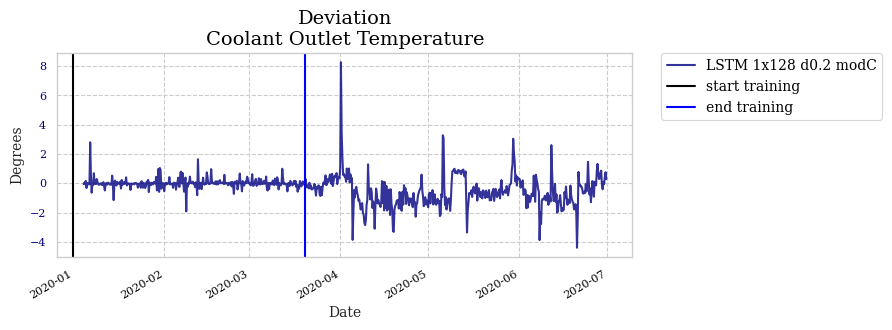

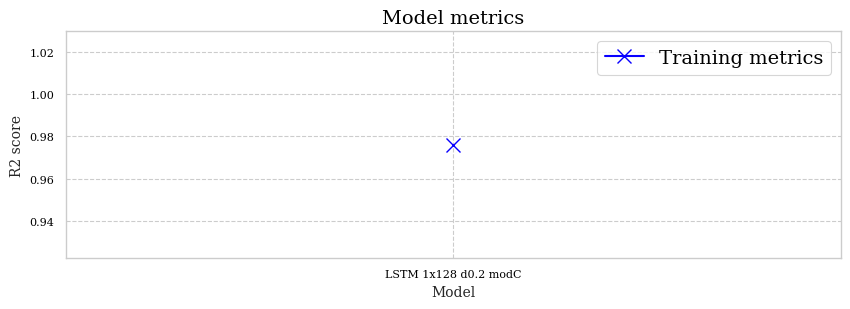

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50PT001 - Coolant Inlet Pressure
Col. 5 : 50TT002 - Coolant Outlet Temperature
Col. 6 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model L

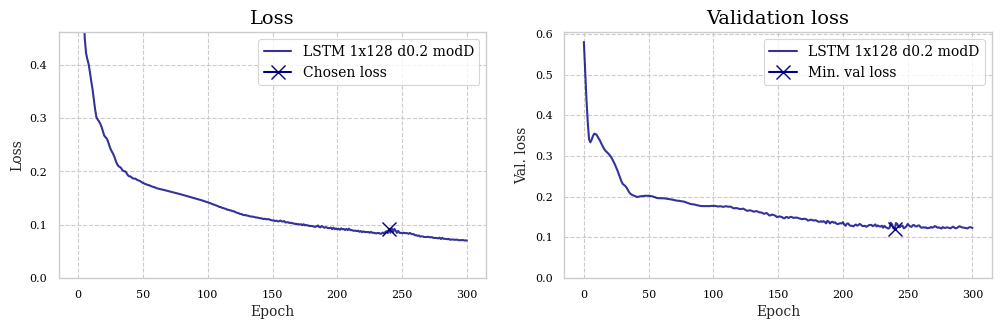

Model prediction scores
+----------------------+-------------+------------+
|        Model         | Train score | Test score |
+----------------------+-------------+------------+
| LSTM 1x128 d0.2 modD |    0.9684   |   0.6538   |
+----------------------+-------------+------------+


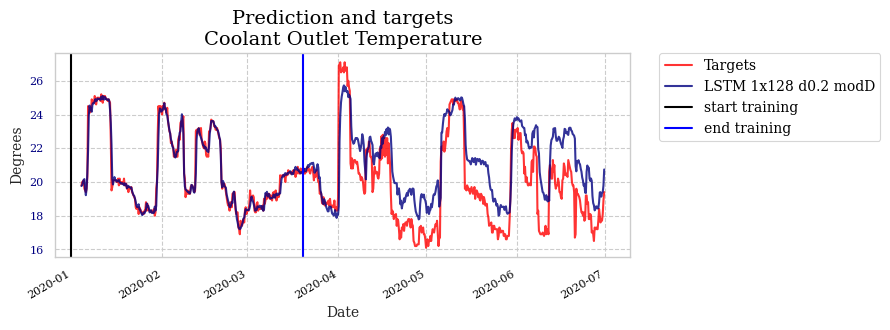

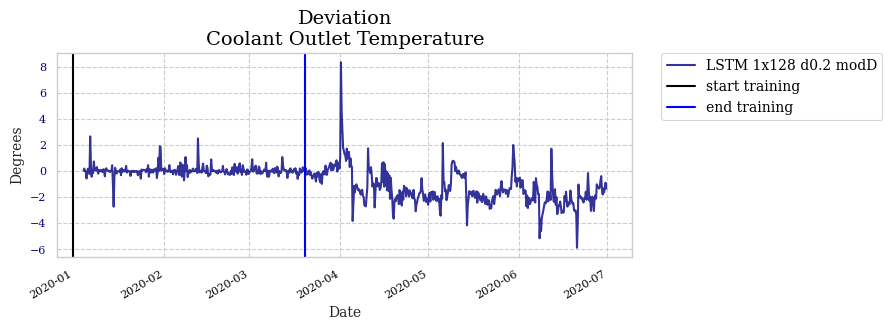

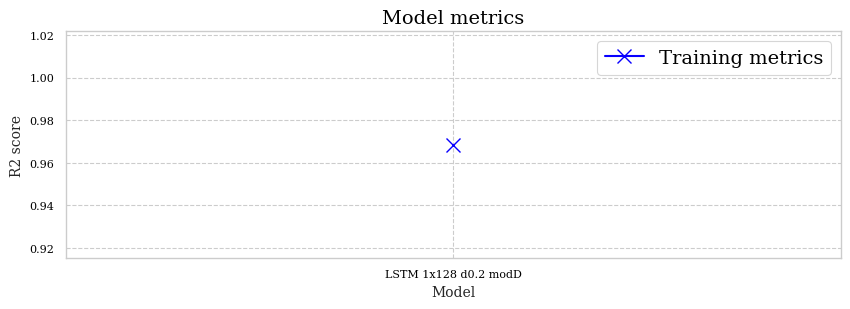

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50PT001 - Coolant Inlet Pressure
Col. 5 : 50FT001 - Coolant Flow Rate
Col. 6 : 50TT002 - Coolant Outlet Temperature
Col. 7 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-0

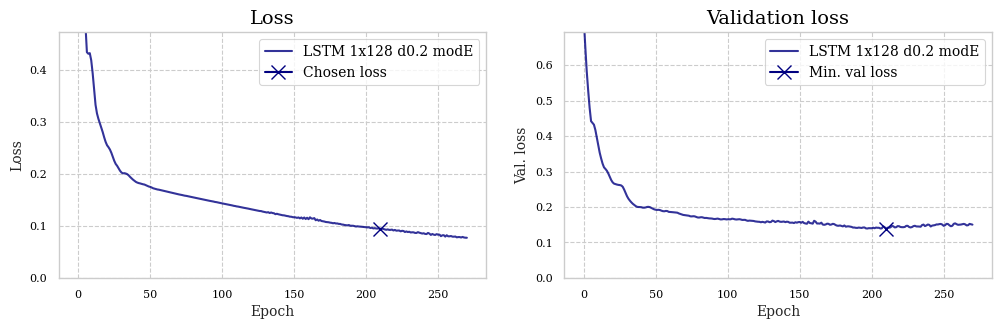

Model prediction scores
+----------------------+-------------+------------+
|        Model         | Train score | Test score |
+----------------------+-------------+------------+
| LSTM 1x128 d0.2 modE |    0.9604   |   0.8507   |
+----------------------+-------------+------------+


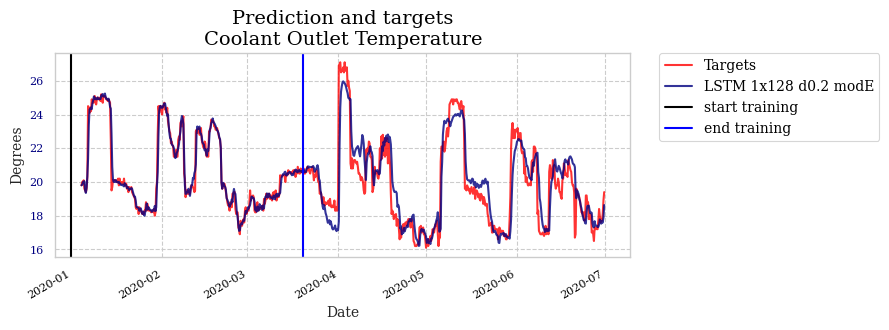

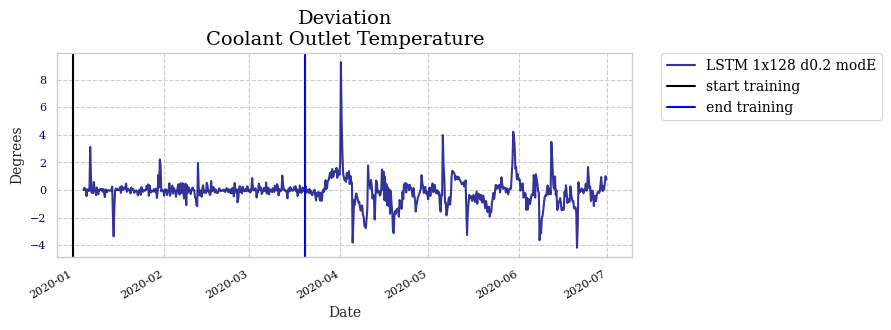

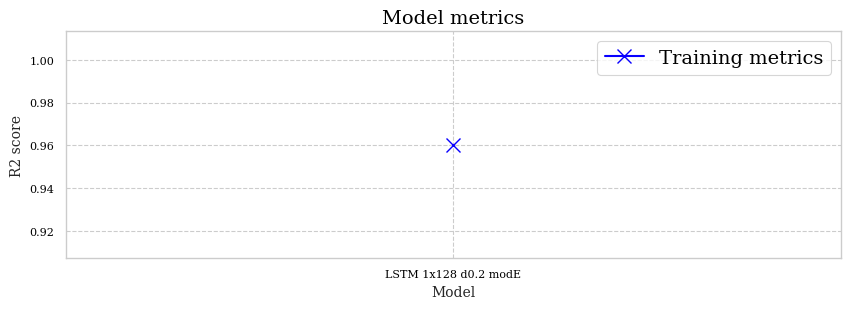

Model prediction scores
+----------------------+-------------+------------+
|        Model         | Train score | Test score |
+----------------------+-------------+------------+
| LSTM 1x128 d0.2 modA |    0.9698   |   0.4128   |
| LSTM 1x128 d0.2 modB |    0.9623   |   0.8373   |
| LSTM 1x128 d0.2 modC |    0.9761   |   0.8493   |
| LSTM 1x128 d0.2 modD |    0.9684   |   0.6538   |
| LSTM 1x128 d0.2 modE |    0.9604   |   0.8507   |
+----------------------+-------------+------------+


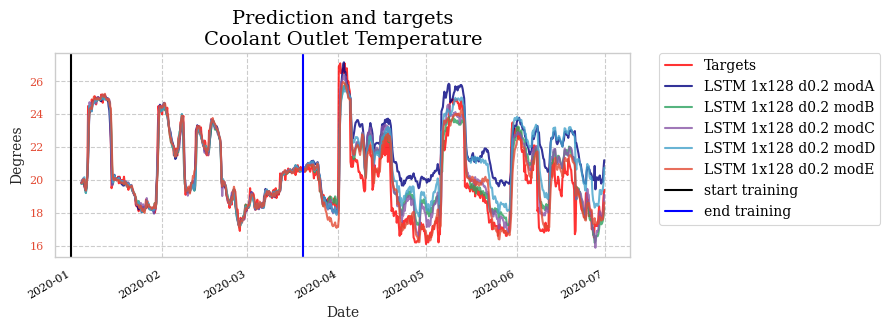

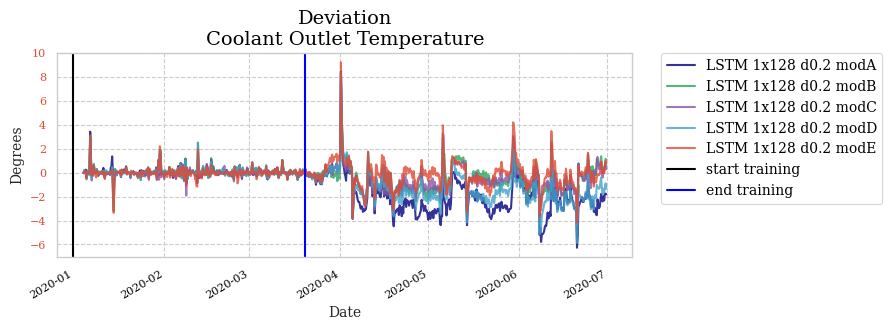

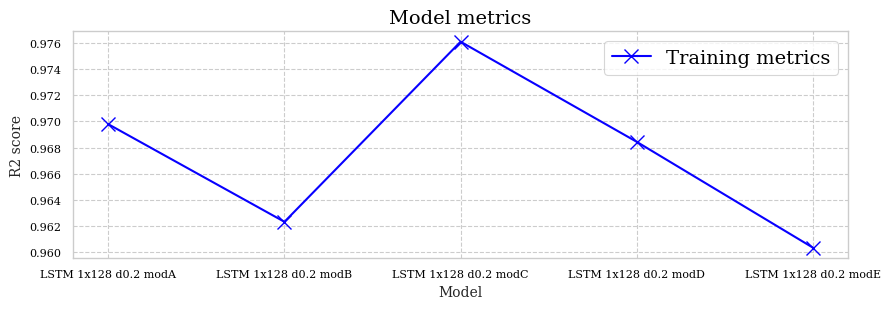

In [5]:
featureComparison(irrelevantColumnsList, filename, columns, traintime, testtime, targetColumns, 2)

# Dataset F, predictive models A-B, 30min

In [6]:
filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig('F', None, '30min')
targetColumns = [
	'TT0653_MA_Y'
]
irrelevantColumnsList = [
	#  Target: C T out
	#  Featers: P T in, P T out, P flow, C T in 
	[
		'FT0111',
		'PDT0108_MA_Y',
		'PDT0119_MA_Y',
		'PDT0118_MA_Y',
		'TT0104_MA_Y',
		'TIC0103_CA_YX',
		'TI0115_MA_Y',
		'TT0652_MA_Y',
		'TIC0103_CA_Y',
		'PIC0104_CA_YX',
		'TIC0101_CA_Y',
		'TT0102_MA_Y',
		'TIC0101_CA_YX',
		'TT0651_MA_Y',
		'TIC0105_CA_Y',
	],
	#  Target: C T out
	#  Featers: P T in, P T out, P flow, C T in, C valve
	[
		'FT0111',
		'PDT0108_MA_Y',
		'PDT0119_MA_Y',
		'PDT0118_MA_Y',
		'TT0104_MA_Y',
		'TIC0103_CA_YX',
		'TI0115_MA_Y',
		'TT0652_MA_Y',
		'TIC0103_CA_Y',
		'PIC0104_CA_YX',
		'TIC0101_CA_Y',
		'TT0102_MA_Y',
		'TIC0101_CA_YX',
		'TT0651_MA_Y',
	],
]

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Valve Opening C

Columns after removal: 
Col. 0 : FYN0111 - Process 

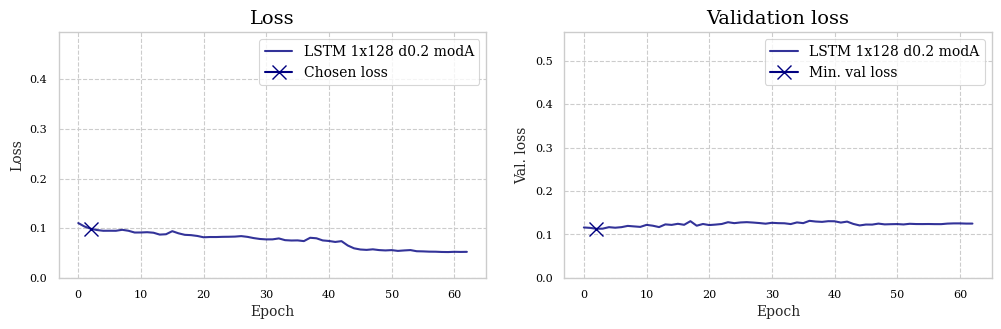

Model prediction scores
+----------------------+-------------+------------+
|        Model         | Train score | Test score |
+----------------------+-------------+------------+
| LSTM 1x128 d0.2 modA |    0.9606   |  -0.2125   |
+----------------------+-------------+------------+


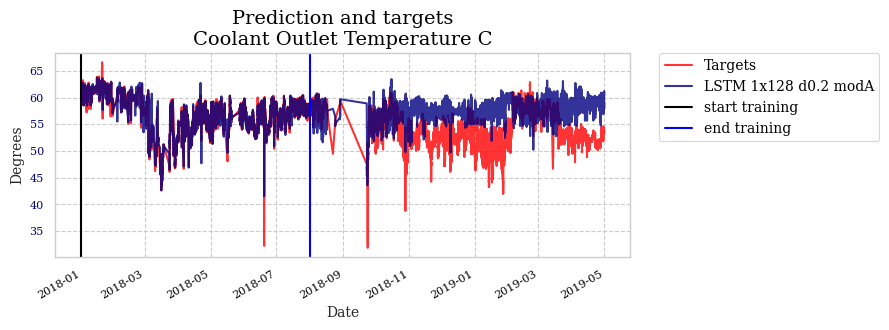

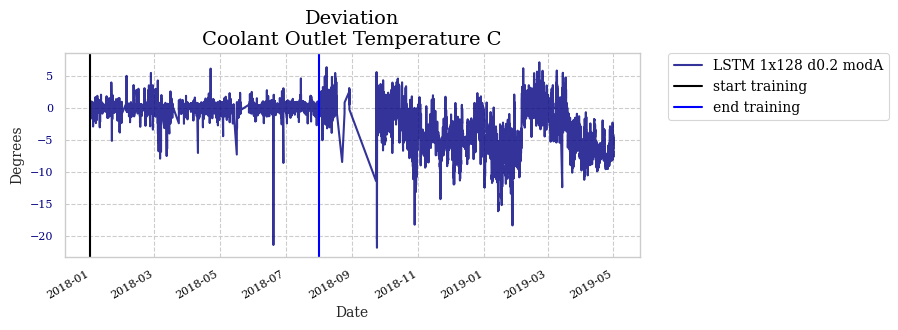

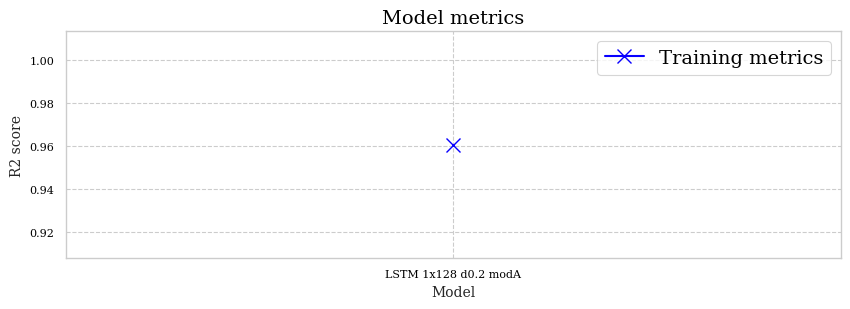

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Valve Opening C

Columns after removal: 
Col. 0 : FYN0111 - Process 

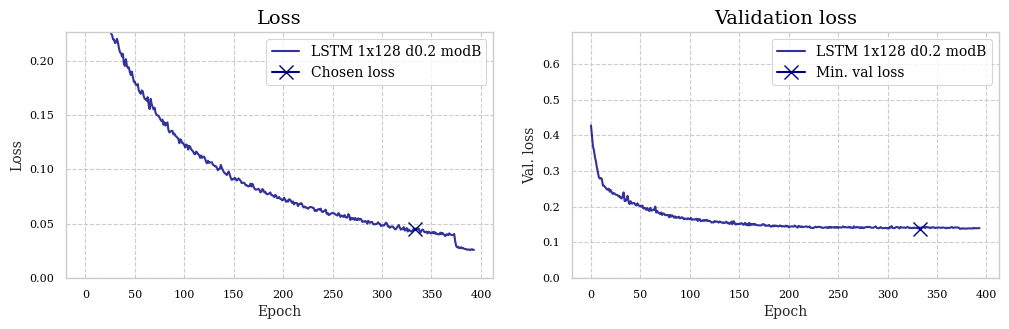

Model prediction scores
+----------------------+-------------+------------+
|        Model         | Train score | Test score |
+----------------------+-------------+------------+
| LSTM 1x128 d0.2 modB |     0.98    |  -0.1445   |
+----------------------+-------------+------------+


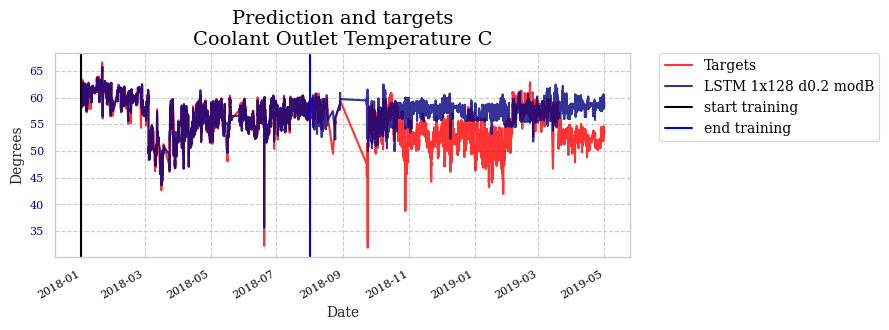

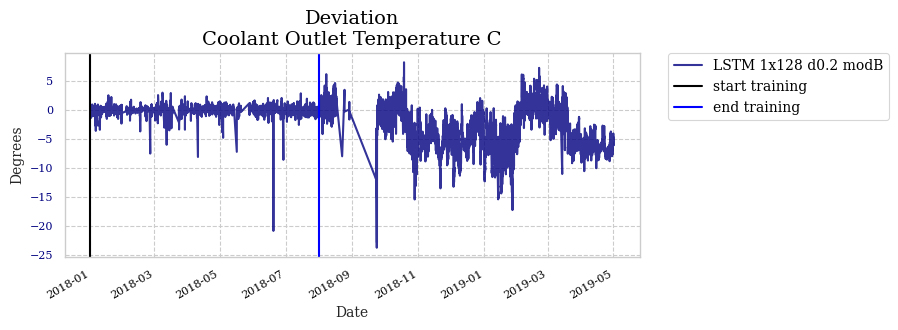

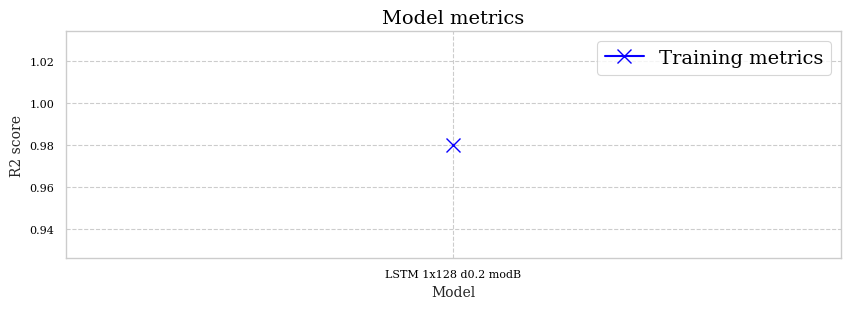

Model prediction scores
+----------------------+-------------+------------+
|        Model         | Train score | Test score |
+----------------------+-------------+------------+
| LSTM 1x128 d0.2 modA |    0.9606   |  -0.2125   |
| LSTM 1x128 d0.2 modB |     0.98    |  -0.1445   |
+----------------------+-------------+------------+


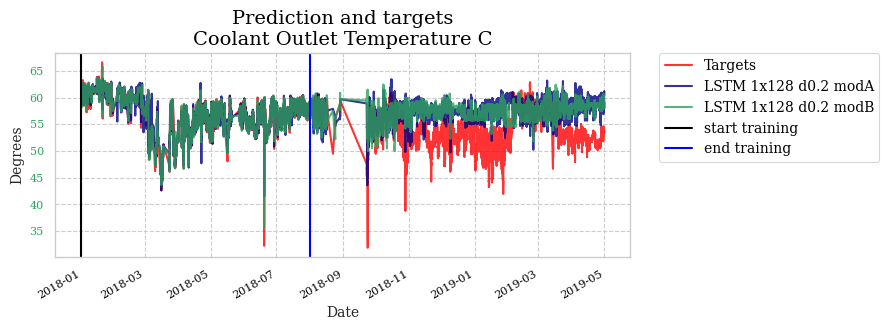

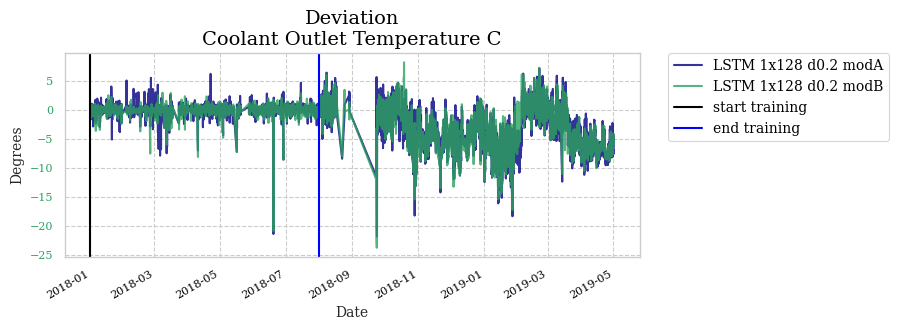

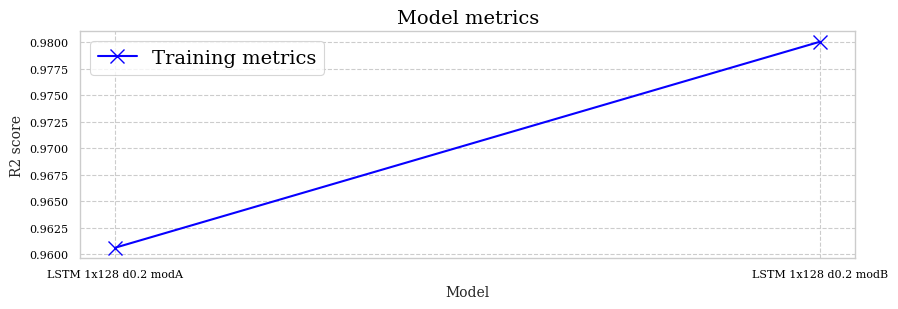

In [7]:
featureComparison(irrelevantColumnsList, filename, columns, traintime, testtime, targetColumns, 16)

# Dataset G, predictive models A-E, 30min

In [8]:
filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig('G', None, '30min')
targetColumns = [
    'TT0026',
]
irrelevantColumnsList = [
	#  Target: C T out
	#  Features: P T in, P T out, P flow, C T in 
	[
		'PDT0024',
		'FI0027',
		'TIC0022U',
		'PI0001',
	    'PDI0064',
	],
	#  Target: C T out
	#  Features: P T in, P T out, P flow, C T in, C valve
	[
		'PDT0024',
		'FI0027',
		'PI0001',
	    'PDI0064',
	],
	#  Target: C T out
	#  Features: P T in, P T out, P flow, C T in, C flow
	[
		'PDT0024',
		'TIC0022U',
		'PI0001',
	    'PDI0064',
	],
	#  Target: C T out
	#  Features: P T in, P T out, P flow, C T in, C P in, C valve
	[
		'PDT0024',
		'FI0027',
	    'PDI0064',
	],
	#  Target: C T out
	#  Features: P T in, P T out, P flow, C T in, C P in, C valve, C flow
	[
		'PDT0024',
	    'PDI0064',
	],
]

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model LSTM 1x128 d0.2 modA was loaded from file
+----------------------+-----------+-------------+---------------+--------+
|        Model   

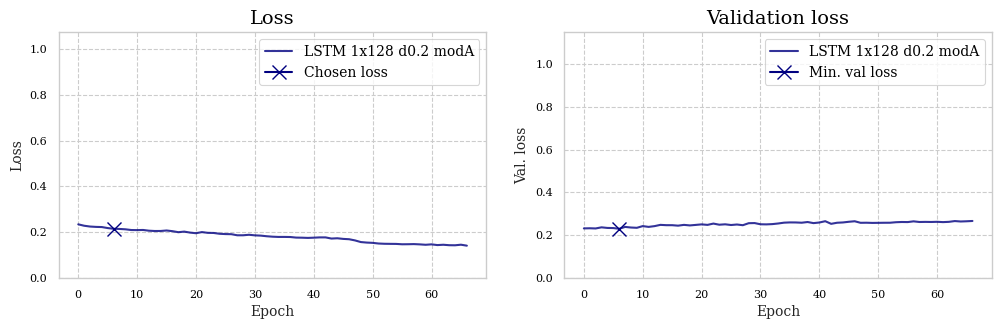

Model prediction scores
+----------------------+-------------+------------+
|        Model         | Train score | Test score |
+----------------------+-------------+------------+
| LSTM 1x128 d0.2 modA |    0.8797   |  -1.4088   |
+----------------------+-------------+------------+


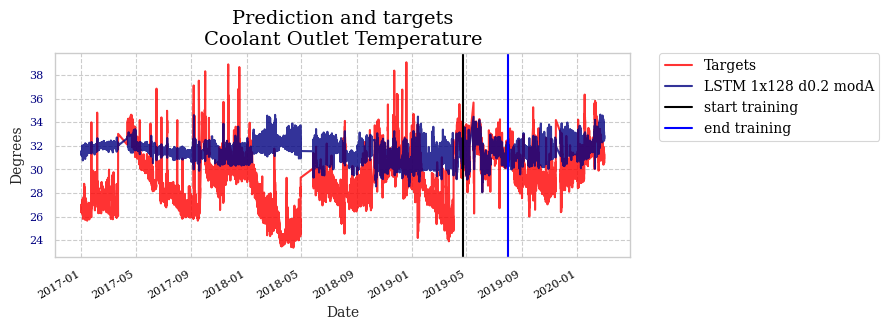

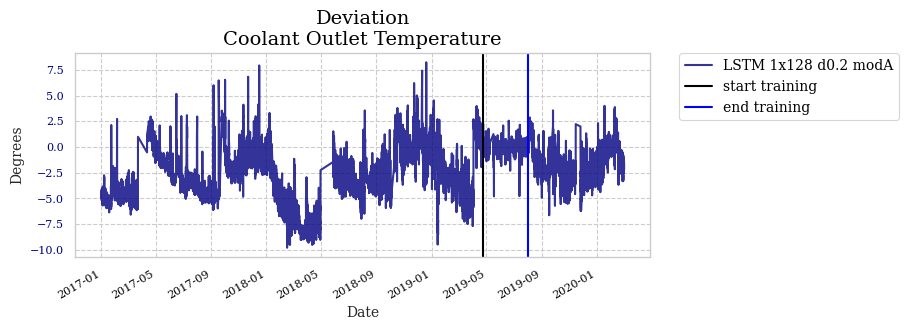

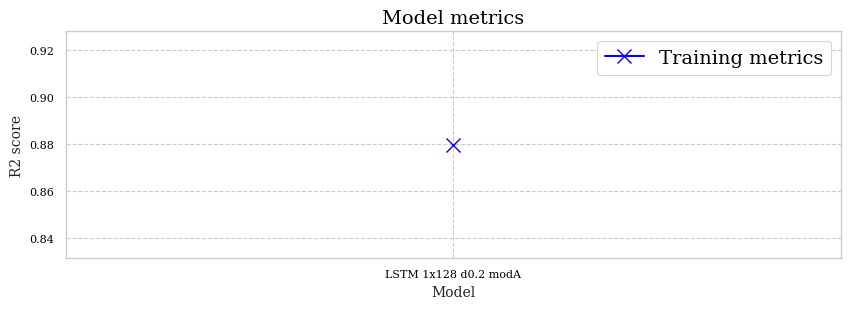

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature
Col. 5 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model LSTM 1x128 d0.2 modB was loaded from file
+----------------------+-----------+-------------+-

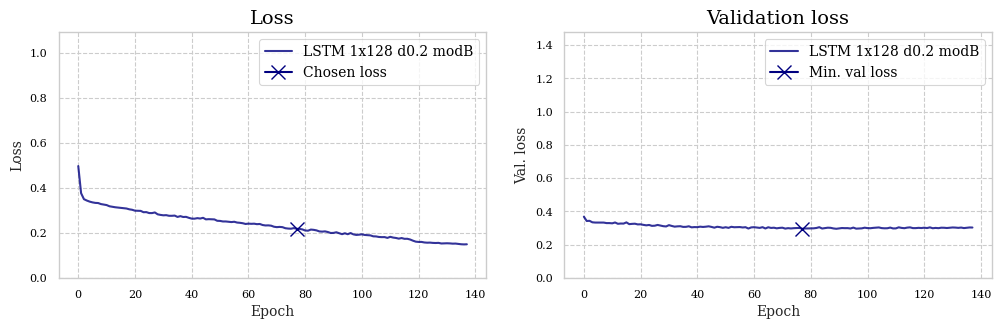

Model prediction scores
+----------------------+-------------+------------+
|        Model         | Train score | Test score |
+----------------------+-------------+------------+
| LSTM 1x128 d0.2 modB |    0.8588   |  -0.3535   |
+----------------------+-------------+------------+


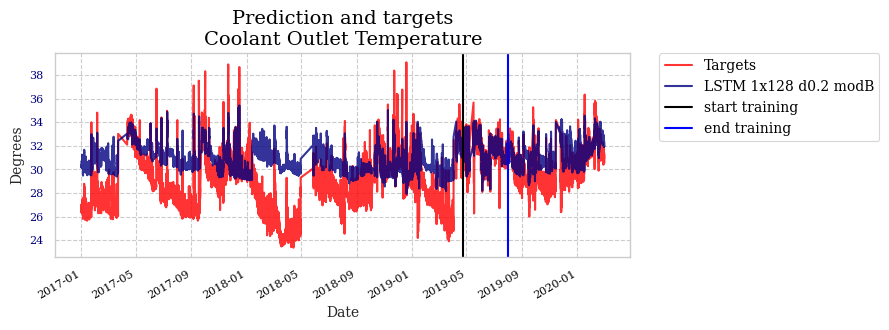

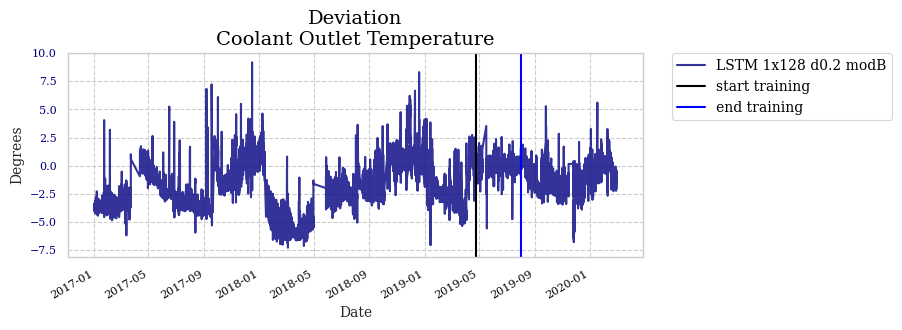

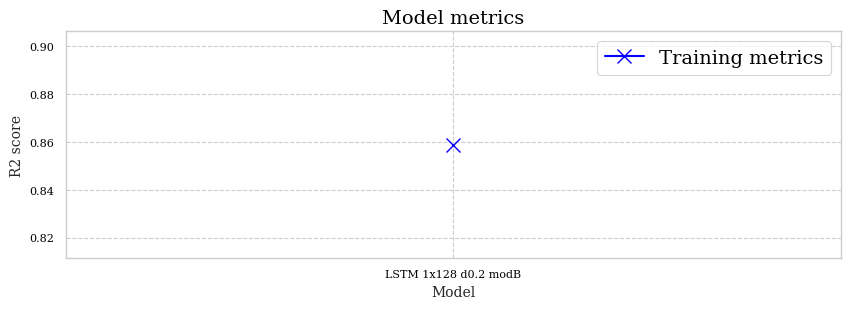

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature
Col. 5 : FI0027 - Coolant Flow Rate

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model LSTM 1x128 d0.2 modC was loaded from file
+----------------------+-----------+-------------+-------

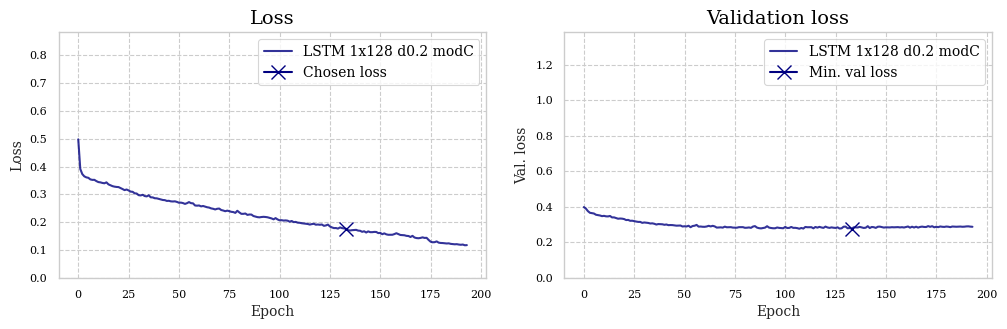

Model prediction scores
+----------------------+-------------+------------+
|        Model         | Train score | Test score |
+----------------------+-------------+------------+
| LSTM 1x128 d0.2 modC |    0.892    |  -0.7249   |
+----------------------+-------------+------------+


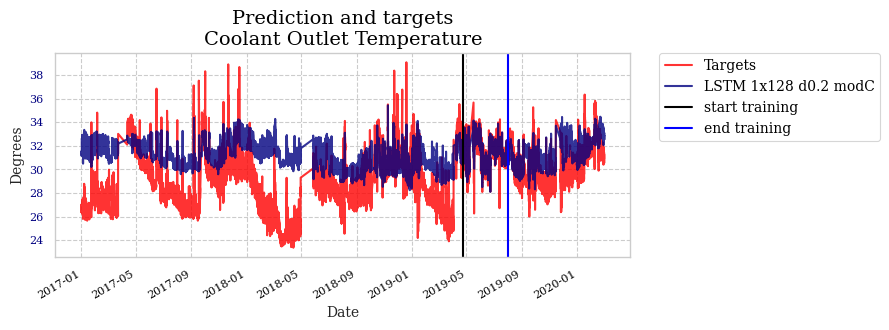

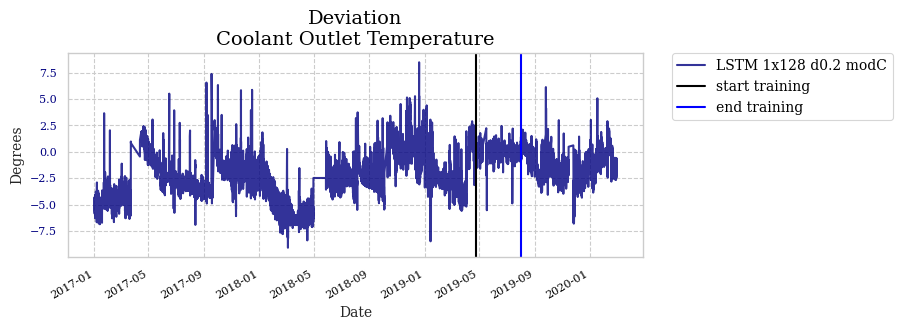

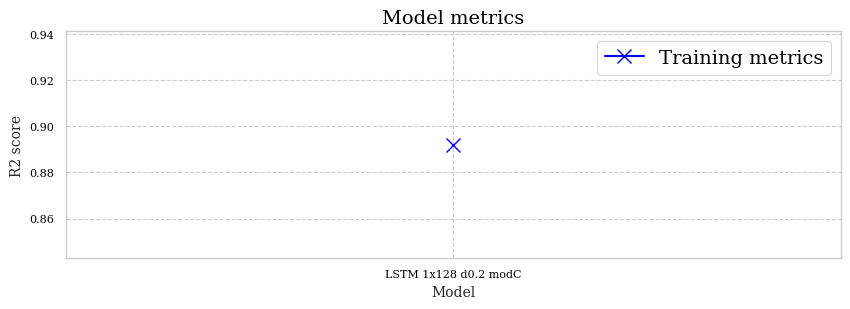

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature
Col. 5 : PI0001 - Coolant Inlet Pressure
Col. 6 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model LSTM 1x128 d0.2 modD was loaded from file
+---------

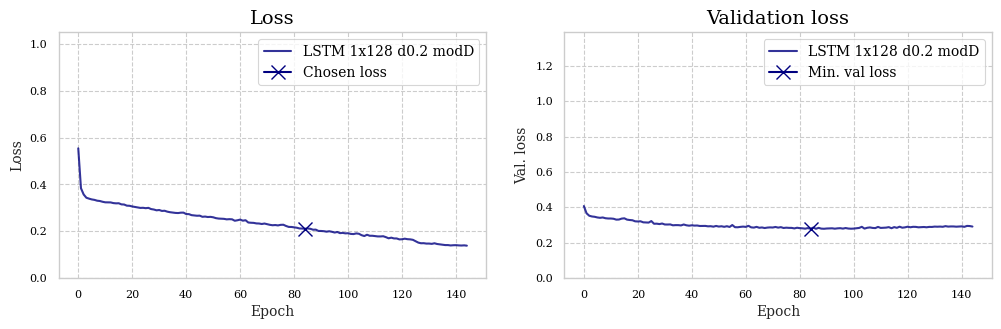

Model prediction scores
+----------------------+-------------+------------+
|        Model         | Train score | Test score |
+----------------------+-------------+------------+
| LSTM 1x128 d0.2 modD |    0.8683   |  -0.0309   |
+----------------------+-------------+------------+


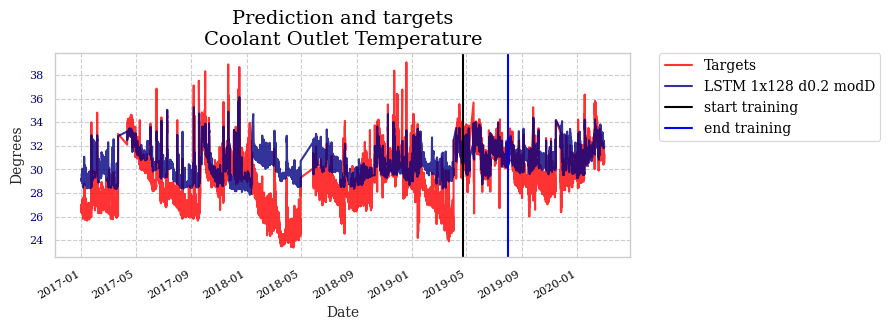

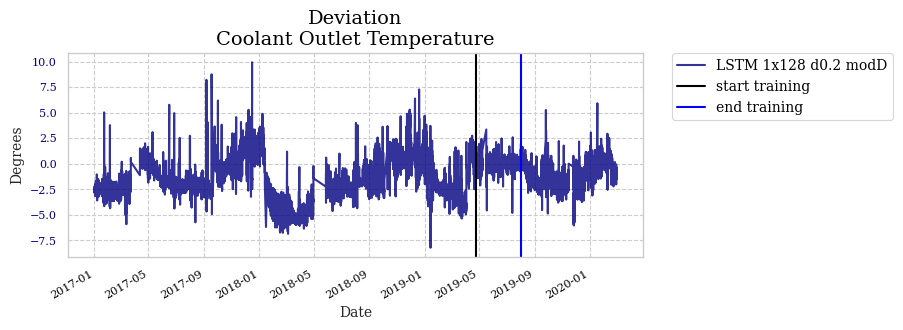

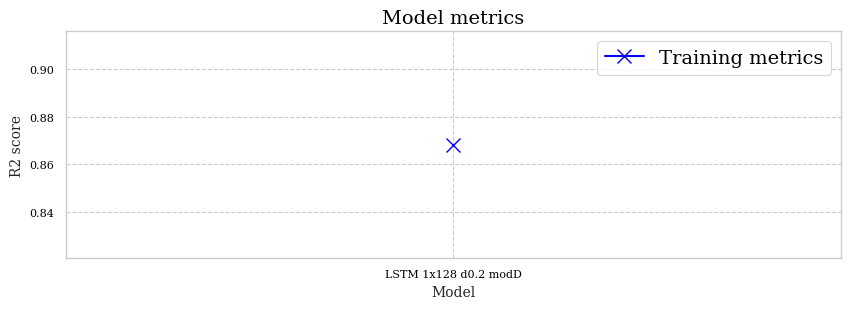

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature
Col. 5 : PI0001 - Coolant Inlet Pressure
Col. 6 : FI0027 - Coolant Flow Rate
Col. 7 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model LSTM 1x128 d0.2 

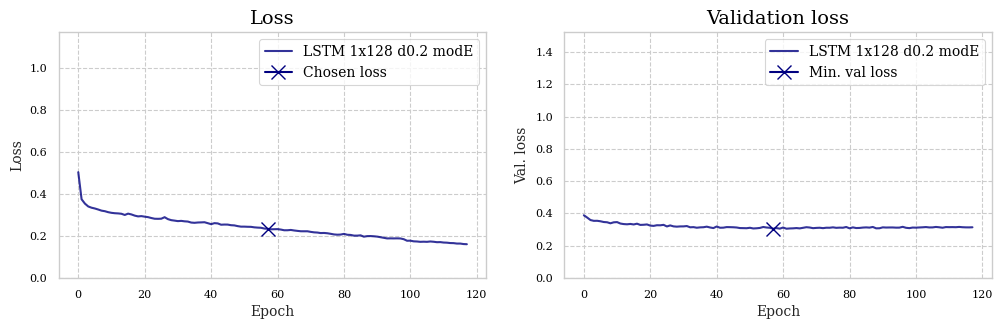

Model prediction scores
+----------------------+-------------+------------+
|        Model         | Train score | Test score |
+----------------------+-------------+------------+
| LSTM 1x128 d0.2 modE |    0.8438   |  -0.0383   |
+----------------------+-------------+------------+


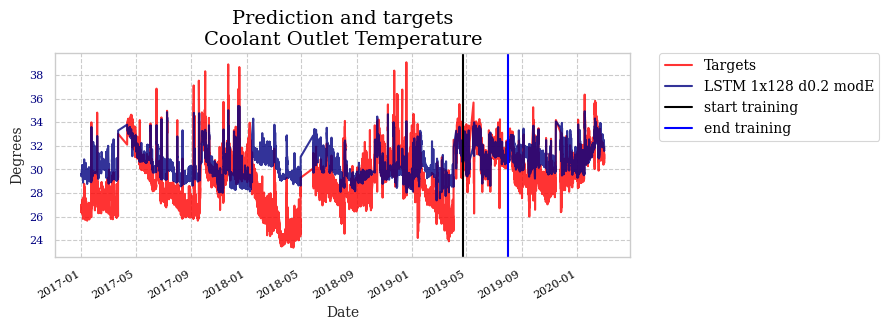

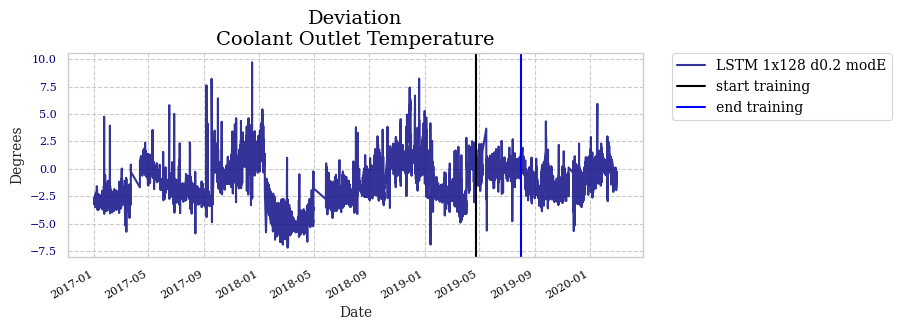

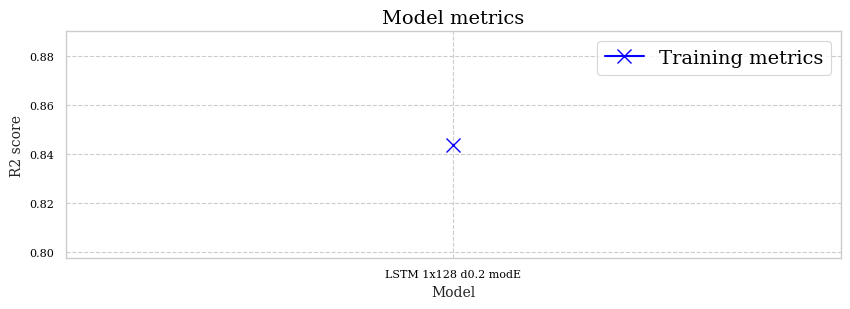

Model prediction scores
+----------------------+-------------+------------+
|        Model         | Train score | Test score |
+----------------------+-------------+------------+
| LSTM 1x128 d0.2 modA |    0.8797   |  -1.4088   |
| LSTM 1x128 d0.2 modB |    0.8588   |  -0.3535   |
| LSTM 1x128 d0.2 modC |    0.892    |  -0.7249   |
| LSTM 1x128 d0.2 modD |    0.8683   |  -0.0309   |
| LSTM 1x128 d0.2 modE |    0.8438   |  -0.0383   |
+----------------------+-------------+------------+


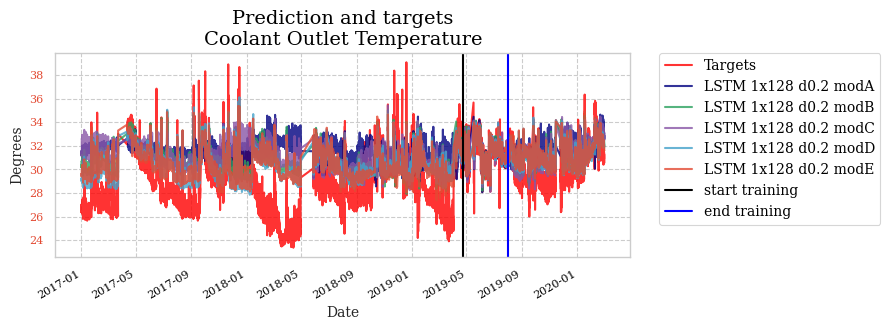

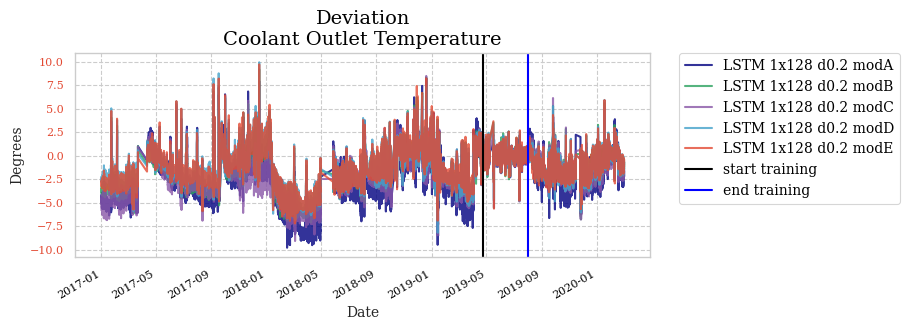

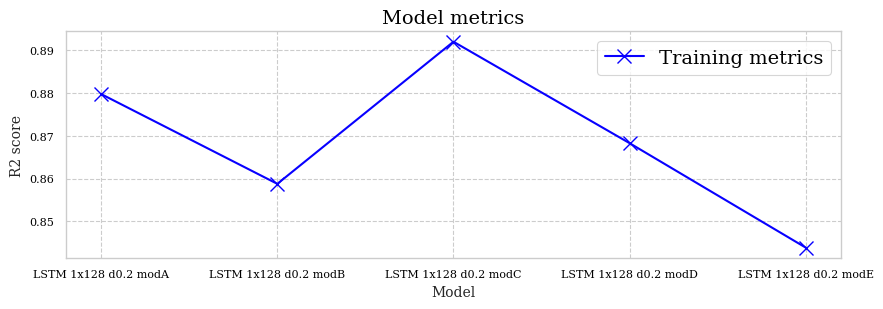

In [9]:
featureComparison(irrelevantColumnsList, filename, columns, traintime, testtime, targetColumns, 16)

# Conclusions
LSTM methods are not applicable for dataset D due to low sampling rate and small sample size. LSTM models using predictive models A, B and C show a lot of promise for datasets F and G. See the thesis for additional details.